In this tutorial, we will build a Convolutional Neural Network (CNN) model to classify images in the CIFAR-10 dataset. This guide assumes no prior experience with machine learning, deep learning, or PyTorch. We'll go through each step with detailed explanations.

### Step 0: Set Up and Install Required Libraries
Before starting, you need to install the necessary libraries. Open a terminal and use the following pip commands to install them.

In [ ]:
!pip install torch torchvision

# Install Matplotlib for plotting
!pip install matplotlib

'''
torch: PyTorch is a deep learning library used to create and train neural networks.
torchvision: Contains common datasets, model architectures, and image transformations, specifically useful for vision-related tasks.
matplotlib: A library for creating visualizations, which we'll use to plot training and testing accuracy.
'''

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Step 1: Define Hyperparameters
Hyperparameters are parameters set before training that control the training process. 
Choosing good values for these hyperparameters is essential for training an effective model.
In this tutorial, we define the following hyperparameters:
1. **batch_size**: The number of images to process in one pass (or batch). 
   Higher values mean faster computation, but may require more memory.
2. **learning_rate**: The rate at which the model's weights are updated. 
   Smaller values lead to slow but steady training, while larger values can make training unstable.
3. **num_epochs**: The number of complete passes through the training dataset. 
   More epochs allow the model to learn more but can lead to overfitting if set too high.


In [2]:
# Hyperparameters
batch_size = 32        # Number of images in each batch
learning_rate = 0.001  # Step size for optimizing weights
num_epochs = 10        # Number of times to go through the entire dataset

### Step 1: Load and Preprocess the CIFAR-10 Dataset
The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class. 
The classes include airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

To prepare the data for training, we need to:
1. Apply transformations like normalization and data augmentation.
2. Split the dataset into training and testing sets.

In [ ]:
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader

# Define the transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomCrop(32, padding=4),  # Crop the image to 32x32 with padding for augmentation
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

# Load CIFAR-10 training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders to iterate over batches
'''
Dataloader is an iterable that abstracts the process of batching, loading, shuffling, and augmenting the data.
It allows you to iterate over the dataset in batches, shuffle the data, and load the data in parallel using multiprocessing workers.
'''
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print the size of the training and test datasets
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of test examples: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 50000
Number of test examples: 10000


### Step 3: Define the CNN Model
A Convolutional Neural Network (CNN) is designed to process images by learning spatial hierarchies of features.

The structure of our CNN model:
1. **Convolutional Layers**: Extract features from images, such as edges, textures, and shapes.
2. **Pooling Layer**: Reduces the spatial dimensions of feature maps, making the model more computationally efficient.
3. **Fully Connected Layers**: Combines all learned features to make final predictions.

### How CNNs Work

The core components of CNNs are **convolutional layers** and **pooling layers**.

1. **Convolutional Layers**:
   - Convolutional layers apply filters (or kernels) to the input image. These filters are small grids, often 3x3 or 5x5, that slide over the image to capture patterns.
   - Filters can detect edges, textures, shapes, and other features. As the network goes deeper, the filters become more complex and specific.
   - The filter values (weights) are learned during the training process.

   **Example of Convolution Operation**:
   - The image below shows a basic convolution operation where a 3x3 filter is applied to a part of the input image.
   
   ![Convolution Example](images/cnn1.png)

   - As shown, the 3x3 filter moves across the image and performs element-wise multiplication with the pixel values in the local region of the image. The results are summed up to form a single output pixel. This process repeats as the filter slides across the image.

2. **Pooling Layers**:
   - Pooling layers are typically used after convolutional layers to reduce the spatial dimensions of the feature maps, making the model more computationally efficient and reducing overfitting.
   - The most common pooling operation is **max pooling**, which takes the maximum value from each patch of the feature map.
   
   Example of Max Pooling:
   
   ![Max Pooling](images/cnn2.svg)

3. **Fully Connected Layers**:
   - After several convolutional and pooling layers, the high-level reasoning in the neural network is handled by fully connected layers.
   - These layers take the features extracted by previous layers and use them to classify the image.

#### Putting It All Together

A CNN architecture for image classification often looks like this:

1. Start with one or more convolutional layers to learn low-level features from the images, such as edges or textures.
2. Add pooling layers to reduce the spatial size of the feature maps.
3. Increase the number of convolutional layers to learn more complex patterns as we go deeper.
4. Finish with fully connected layers to combine all the learned features and make a final prediction.

Below is a visual summary of how a CNN processes an image through multiple layers.

![CNN Architecture](images/cnn3.jpg)

#### Key Terms

- **Filter (Kernel)**: A small matrix (e.g., 3x3 or 5x5) used to scan over the input image and extract specific features.
- **Stride**: The number of pixels by which the filter matrix moves across the input image.
- **Padding**: Adding extra pixels around the input image to maintain the output size.

By understanding these components, we can now proceed to implement a CNN model for classifying images from the CIFAR-10 dataset.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Define three convolutional layers with increasing filter sizes
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        # Pooling layer for downsampling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define two fully connected layers for classification
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        
        # Flatten the output of the convolutional layers, so it become 1 dimension vector
        self.flatten = nn.Flatten()
        
        # ReLu activation function, to introduce non-linearity
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu(x)
        
        x = self.fc2(x)
        return x

# Initialize the model
model = CNNModel().to(device)

### Step 4: Define the Loss Function and Optimizer
- **Loss Function**: Measures how well the model's predictions match the actual labels. We use CrossEntropyLoss for classification.
- **Optimizer**: Updates model parameters to minimize the loss function. We use Adam, which adapts the learning rate for each parameter.


In [5]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


### Step 5: Train the Model
In this step, we train the model over multiple epochs. During each epoch, we:
1. **Feed the training data**: Pass images through the model.
2. **Calculate the loss**: Measure the difference between the predicted and actual labels.
3. **Update weights**: Adjust model parameters to reduce the loss.


In [ ]:
# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

### Step 6: Test the Model
After training, we evaluate the model on the test data to measure its performance on unseen images.


In [7]:
# Testing function
def test(model, loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Track loss and accuracy
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

### Step 7: Run Training and Testing
Now we train the model for multiple epochs and test it after each epoch to observe its improvement over time.

In [8]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)
    
    # Store the results for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")


Epoch [1/10], Train Loss: 1.5096, Train Acc: 44.34%, Test Loss: 1.2150, Test Acc: 55.97%
Epoch [2/10], Train Loss: 1.1235, Train Acc: 59.73%, Test Loss: 1.0159, Test Acc: 63.96%
Epoch [3/10], Train Loss: 0.9474, Train Acc: 66.53%, Test Loss: 0.9581, Test Acc: 66.93%
Epoch [4/10], Train Loss: 0.8529, Train Acc: 69.88%, Test Loss: 0.8651, Test Acc: 70.20%
Epoch [5/10], Train Loss: 0.7884, Train Acc: 72.21%, Test Loss: 0.8322, Test Acc: 71.21%
Epoch [6/10], Train Loss: 0.7357, Train Acc: 74.12%, Test Loss: 0.7827, Test Acc: 72.88%
Epoch [7/10], Train Loss: 0.6964, Train Acc: 75.64%, Test Loss: 0.7380, Test Acc: 74.56%
Epoch [8/10], Train Loss: 0.6708, Train Acc: 76.53%, Test Loss: 0.7047, Test Acc: 75.49%
Epoch [9/10], Train Loss: 0.6442, Train Acc: 77.43%, Test Loss: 0.7349, Test Acc: 74.87%
Epoch [10/10], Train Loss: 0.6203, Train Acc: 78.47%, Test Loss: 0.7378, Test Acc: 75.18%


### Step 8: Plot the Results
Let's visualize the training and testing accuracy over epochs to see the model's progress.


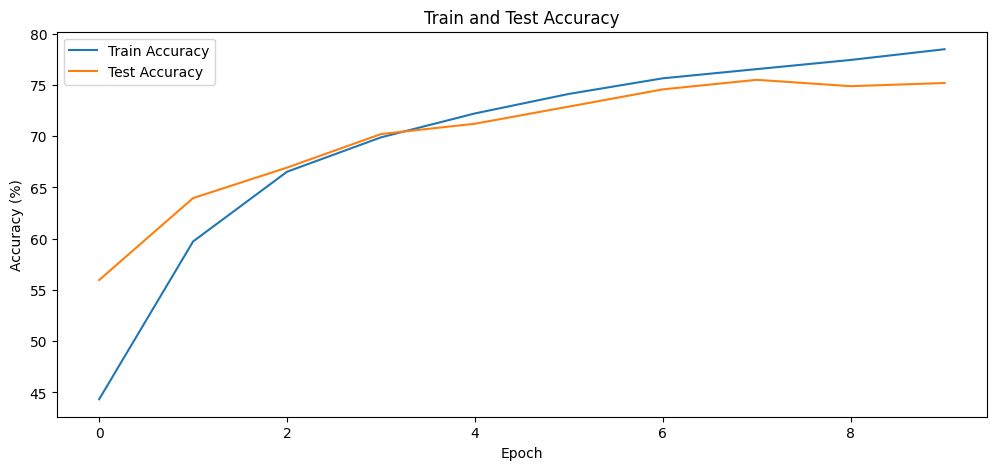

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Test Accuracy')
plt.legend()
plt.show()

### Step 9: Save the Model
Finally, save the trained model to use it later for predictions or further training.

In [ ]:
torch.save(model.state_dict(), 'cnn_cifar10.pth')
print("Model saved as cnn_cifar10.pth")